# Réalisez une application de recommandation de contenus


In [1]:
import sys

sys.path.append("src/")

In [2]:
import projet9_functions as p9
import pandas as pd

Preprocessing des données : jointure des fichiers de clics


In [ ]:
p9.join_data()

## Test d'un système de recommandation par popularité des articles


In [2]:
!{sys.executable} src/popularity.py

2023-11-08 18:11:32.160495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-08 18:11:32.160561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-08 18:11:32.160569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/08 18:11:33 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/08 18:11:33 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

## Test d'un système de recommandation basé sur le contenu des articles


In [12]:
!{sys.executable} src/content_based.py

2023-11-13 17:06:30.036128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:06:30.036197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:06:30.036205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/13 17:06:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/13 17:06:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

Les performances du système par recommandation basé sur le contenu sont très faibles, plus faibles encore que la baseline basée sur la popularité. Pour savoir pourquoi, la figure ci-dessous montre une distribution de la similarité moyenne entre articles lus par utilisateur.


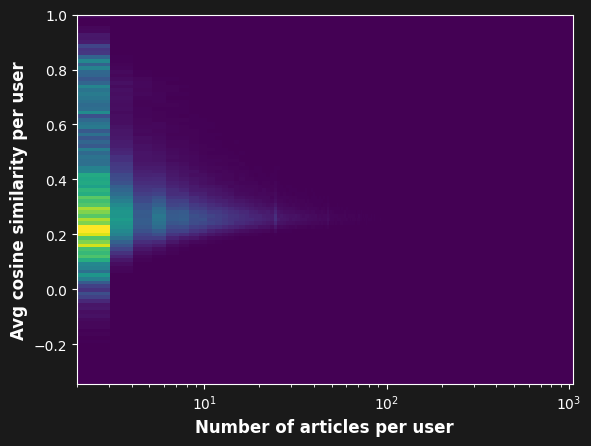

In [3]:
df = pd.read_csv("data/clicks.csv")
p9.get_average_similarity(df)

## Test d'un système de recommandation basé sur le collaborative filtering


Le premier essai consiste à utiliser l'algorithme populaire du SVD++.


In [14]:
!{sys.executable} src/SVD.py

2023-11-13 17:27:42.500739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:27:42.500806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:27:42.500814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/13 17:27:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/13 17:27:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

Le deuxième essai est une factorization machine _LightFM_. Contrairement au SVD++ qui cherche à optimiser le scoring grâce à la RMSE, elle tente d'optimiser le ranking grâce à la loss WARP.


In [47]:
!{sys.executable} src/model_lightfm.py

2023-11-21 15:06:40.768672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-21 15:06:40.768738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-21 15:06:40.768747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/21 15:06:42 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/21 15:06:42 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

Un troisième essai consiste à tester l'algorithme de _Bayesian personalized ranking_. Contrairement aux deux précédents, cet algorithme ne cherche pas à prédire des scores, mais des différences de scores, et donc à optimiser le ranking.


In [119]:
!{sys.executable} src/bpr.py

2023/11/30 15:23:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/30 15:23:59 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
model
  6%|▍        | 11/200 [00:02<00:43,  4.39it/s, train_auc=50.65%, skipped=4.04%]^C


## Test d'un système de recommandation hybride


On teste ici un algorithme hybride qui utilise le système de recommandation par popularité et le BPR. La prédiction se fait en fonction d'un seuil sur le nombre d'articles déjà lus par un utilisateur.<br>
On cherche ici à hyperparamétriser cet algorithme selon deux hyperparamètres :

- le seuil utilisé (nombre d'articles)
- le nombre de facteurs utilisés par le BPR pour sa projection


In [128]:
!{sys.executable} src/hybrid.py -m

[2023-11-30 15:41:41,618][HYDRA] Launching 16 jobs locally
[2023-11-30 15:41:41,618][HYDRA] 	#0 : n_factor=50 thr_pop=0
2023/11/30 15:41:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/30 15:41:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
100%|████████| 200/200 [00:14<00:00, 14.28it/s, train_auc=97.21%, skipped=4.04%]
apply collaborative filtering recommender
400000it [00:40, 9807.13it/s]
[2023-11-30 15:42:49,115][HYDRA] 	#1 : n_factor=50 thr_pop=3
100%|████████| 200/200 [00:15<00:00, 13.06it/s, train_auc=97.19%, skipped=4.01%]
apply popularity recommender
apply collaborative filtering recommender
400000it [00:25, 15450.51it/s]
[2023-11-30 15:44:23,486][HYDRA] 	#2 : n_factor=50 thr_pop=6
10

Comme on peut le voir sur la figure ci-dessous, la performance globale ne dépend qu'assez peu du nombre de facteurs du BPR. On peut donc choisir le nombre minimum testé (50 facteurs), afin d'avoir un modèle plus léger à déployer.<br>
Par ailleurs, la performance maximale est observée pour les seuils les plus faibles. On a donc intérêt à utiliser le BPR dans la mesure du possible, et ne réserver l'algorithme de recommandation par popularité que dans les cas de pur _cold start_.


Text(0, 0.5, 'MAP@5')

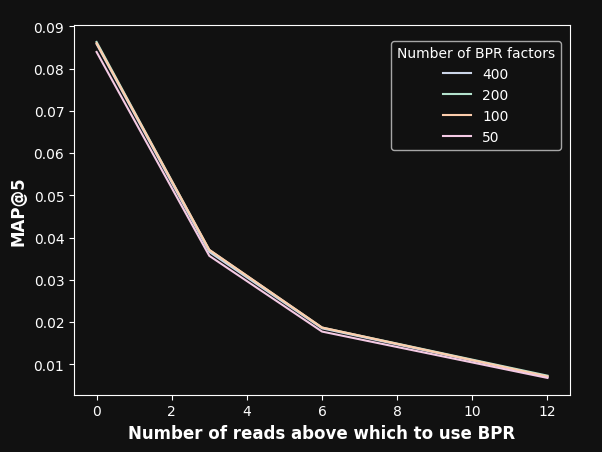

In [14]:
runs = pd.read_csv("runs.csv")
runs = runs[runs["Name"] == "hybrid"]
p9.plot_hyperparam(runs)